In [1]:
import tensorflow as tf

import xml.etree.ElementTree as ET
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset, extract_bboxes, compute_ap
from mrcnn.visualize import display_instances
import matplotlib
import matplotlib.pyplot as plt
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
import itertools

! ls -l kangaroo


/home/bruna/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bruna/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bruna/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bruna/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarnin

total 12
drwxrwxr-x 2 bruna bruna 4096 dez 10 16:34 annots
drwxrwxr-x 2 bruna bruna 4096 dez 10 16:34 images
-rw-rw-r-- 1 bruna bruna   75 dez 10 16:34 README.md


Using TensorFlow backend.


In [2]:
# split into train and test set


# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
    # function to extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ET.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
    
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "kangaroo")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) >= 150:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) < 150:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)


    # load the masks for an image
    def load_mask(self, image_id):
    # We don’t have masks, but we do have bounding boxes. We can load the bounding boxes for a given photo and return them as masks. 
    # The library will then infer bounding boxes from our “masks” which will be the same size.
    # load the masks for an image

        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')
    
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
    
    


In [3]:
def load_my_dataset(is_train=True):
    if is_train:
        train_set = KangarooDataset()
        train_set.load_dataset('kangaroo', is_train=True)
        train_set.prepare()
        print('Train: {}'.format(len(train_set.image_ids)))
        return train_set
    else:
        test_set = KangarooDataset()
        test_set.load_dataset('kangaroo', is_train = False)
        test_set.prepare()
        print('Test: {}'.format(len(test_set.image_ids)))
        return test_set



In [4]:
# train set
train_set = load_my_dataset(is_train=True)

# test/val set
test_set = load_my_dataset(is_train=False)

Train: 131
Test: 32


(333, 400, 3)
(333, 400, 1)


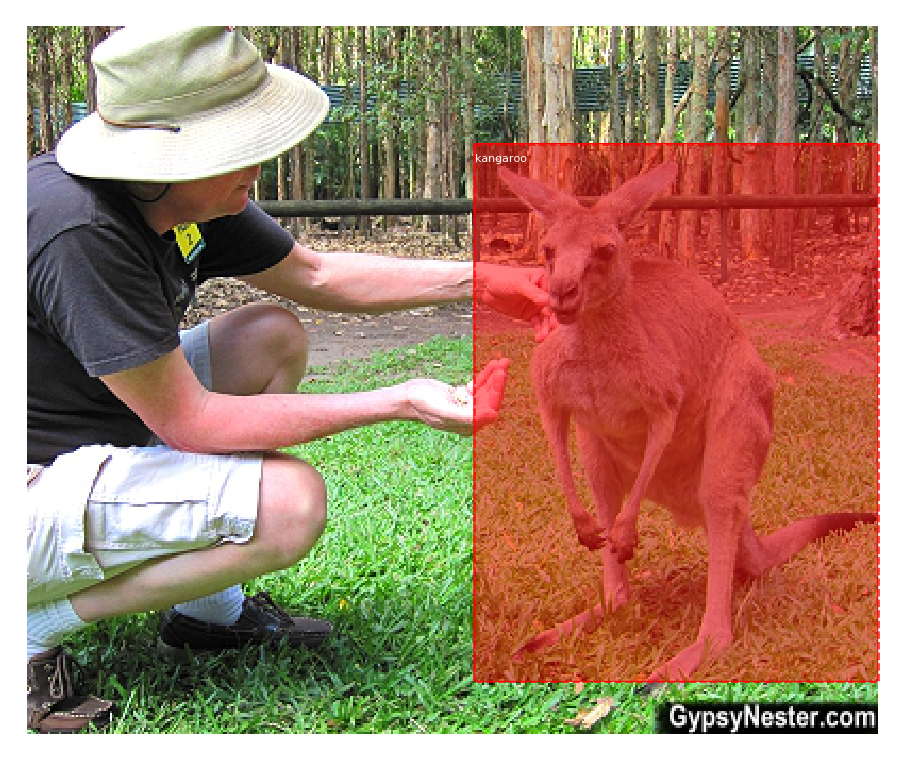

In [5]:
# carrega uma imagem
image_id = 14
image = train_set.load_image(image_id)
print(image.shape)

# carrega a sua respectiva mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

# carrega bbox da mask
bbox = extract_bboxes(mask)

# plota imgem com mask + bbox
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [6]:
# configuração do modelo
class KangarooConfig(Config):
    NAME = "kangaroo_cfg"
    NUM_CLASSES = 2 # background + kangaroo
    STEPS_PER_EPOCH = 150
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    LEARNING_RATE=0.005
    
#     # Skip detections with < 90% confidence
#     DETECTION_MIN_CONFIDENCE = 0.9
    
#     # setting Max ground truth instances
#     MAX_GT_INSTANCES=10
#     IMAGEMINDIM = 256
#     IMAGEMAXDIM = 512
#     RPNANCHORSCALES = (4, 8, 16, 32, 64)
#     TRAINROISPERIMAGE = 500 
#     STEPSPEREPOCH = 600 // (IMAGES_PER_GPU * GPU_COUNT)
#     VALIDATIONSTEPS = 70 // (IMAGES_PER_GPU * GPU_COUNT)
#     MEANPIXEL = [0, 0, 0] 
#     LEARNINGRATE = 0.01
#     USEMINIMASK = True
#     MAXGTINSTANCES = 500



In [7]:
# inicializa configuração
config = KangarooConfig()
# config.display()

model = MaskRCNN(mode='training', model_dir='./', config=config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [8]:
# treina os pesos (output layers ou 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=10, layers='heads')


Starting at epoch 0. LR=0.005

Checkpoint Path: ./kangaroo_cfg20191213T1517/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

/home/bruna/py36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/bruna/py36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/bruna/py36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/bruna/py36/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=T



Epoch 1/10
150/150 [==============================] - 1207s 8s/step - loss: 7.9101 - rpn_class_loss: 0.1584 - rpn_bbox_loss: 4.6901 - mrcnn_class_loss: 0.1151 - mrcnn_bbox_loss: 2.5154 - mrcnn_mask_loss: 0.4311 - val_loss: 6.6668 - val_rpn_class_loss: 0.1489 - val_rpn_bbox_loss: 3.4333 - val_mrcnn_class_loss: 0.0975 - val_mrcnn_bbox_loss: 2.3660 - val_mrcnn_mask_loss: 0.6212
Epoch 2/10
150/150 [==============================] - 1195s 8s/step - loss: 3.1351 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.4327 - mrcnn_class_loss: 0.0837 - mrcnn_bbox_loss: 1.0591 - mrcnn_mask_loss: 0.5104 - val_loss: 6.5247 - val_rpn_class_loss: 0.1773 - val_rpn_bbox_loss: 5.4868 - val_mrcnn_class_loss: 0.0748 - val_mrcnn_bbox_loss: 0.4528 - val_mrcnn_mask_loss: 0.3329
Epoch 3/10
150/150 [==============================] - 1194s 8s/step - loss: 2.3227 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 0.9450 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.7538 - mrcnn_mask_loss: 0.4753 - val_loss: 2.0007 - val_rpn_cl

In [9]:
class PredictionConfig(Config):
    NAME = "kangaroo_cfg"
    NUM_CLASSES = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# calcula mAP do modelo para um dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load imagem, bboxes e masks pra image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # converte os valores dos pixels (e.g. centre)
        scaled_image = mold_image(image, cfg)
        # converte a imagem pra uma amostra
        sample = expand_dims(scaled_image, 0)
        # faz a predição
        yhat = model.detect(sample, verbose=0)
        # extrai os resultados
        r = yhat[0]
        # estatísticas + AP e armazena
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    # media de AP de tds imagens
    mAP = mean(APs)
    return mAP


In [31]:
# AVALIA MODELO
# train set
train_set = load_my_dataset(is_train=True)

# test/val set
test_set = load_my_dataset(is_train=False)
# inicializa configuração
cfg = PredictionConfig()

# inicializa o modelo
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

# carrega os pesos pro modelo
model.load_weights('kangaroo_cfg20191213T1517/mask_rcnn_kangaroo_cfg_0006.h5', by_name=True)

# avalia o modelo no dataset de treino
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: {0:.3f}".format(train_mAP))

# avalia o modelo no dataset de teste
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: {0:.3f}".format(test_mAP))

Train: 131
Test: 32
Train mAP: 0.000
Test mAP: 0.000


In [32]:
# DETECTAR CANGURUS EM NOVAS IMAGENS
# plota imagens: ground truth + predições
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    plt.rcParams["figure.figsize"] = (25,35) 
    for i in range(n_images):
        # carrega imagem + máscara
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # converte valores do pixels (centro)
        scaled_image = mold_image(image, cfg)
        # converte a imagem pra uma amostra
        sample = expand_dims(scaled_image, 0)
        # faz predição
        yhat = model.detect(sample, verbose=0)[0]

        # plota ground truth
        plt.subplot(n_images, 2, i*2+1)
        plt.imshow(image)
        plt.title('Actual')
        
        # plota ground truth masks
        for j in range(mask.shape[2]):
            plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
            
        # contexto pras boxes
        plt.subplot(n_images, 2, i*2+2)
        plt.imshow(image)
        plt.title('Predicted')
        ax = plt.gca()
        # plota cada box
        for box in yhat['rois']:
            y1, x1, y2, x2 = box
            # calcula altura e comprimento das boxes
            width, height = x2 - x1, y2 - y1
            # desenha retângulo
            rect = matplotlib.patches.Rectangle((x1, y1), width, height, fill=False, color='red')
            ax.add_patch(rect)
            
    plt.show()

In [34]:
# train set
train_set = load_my_dataset(is_train=True)

# test/val set
test_set = load_my_dataset(is_train=False)

# inicializa configuração
cfg = PredictionConfig()

# inicializa o modelo
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

# carrega pesos do modelo
model_path = 'kangaroo_cfg20191213T1517/mask_rcnn_kangaroo_cfg_0005.h5'
model.load_weights(model_path, by_name=True)

Train: 131
Test: 32


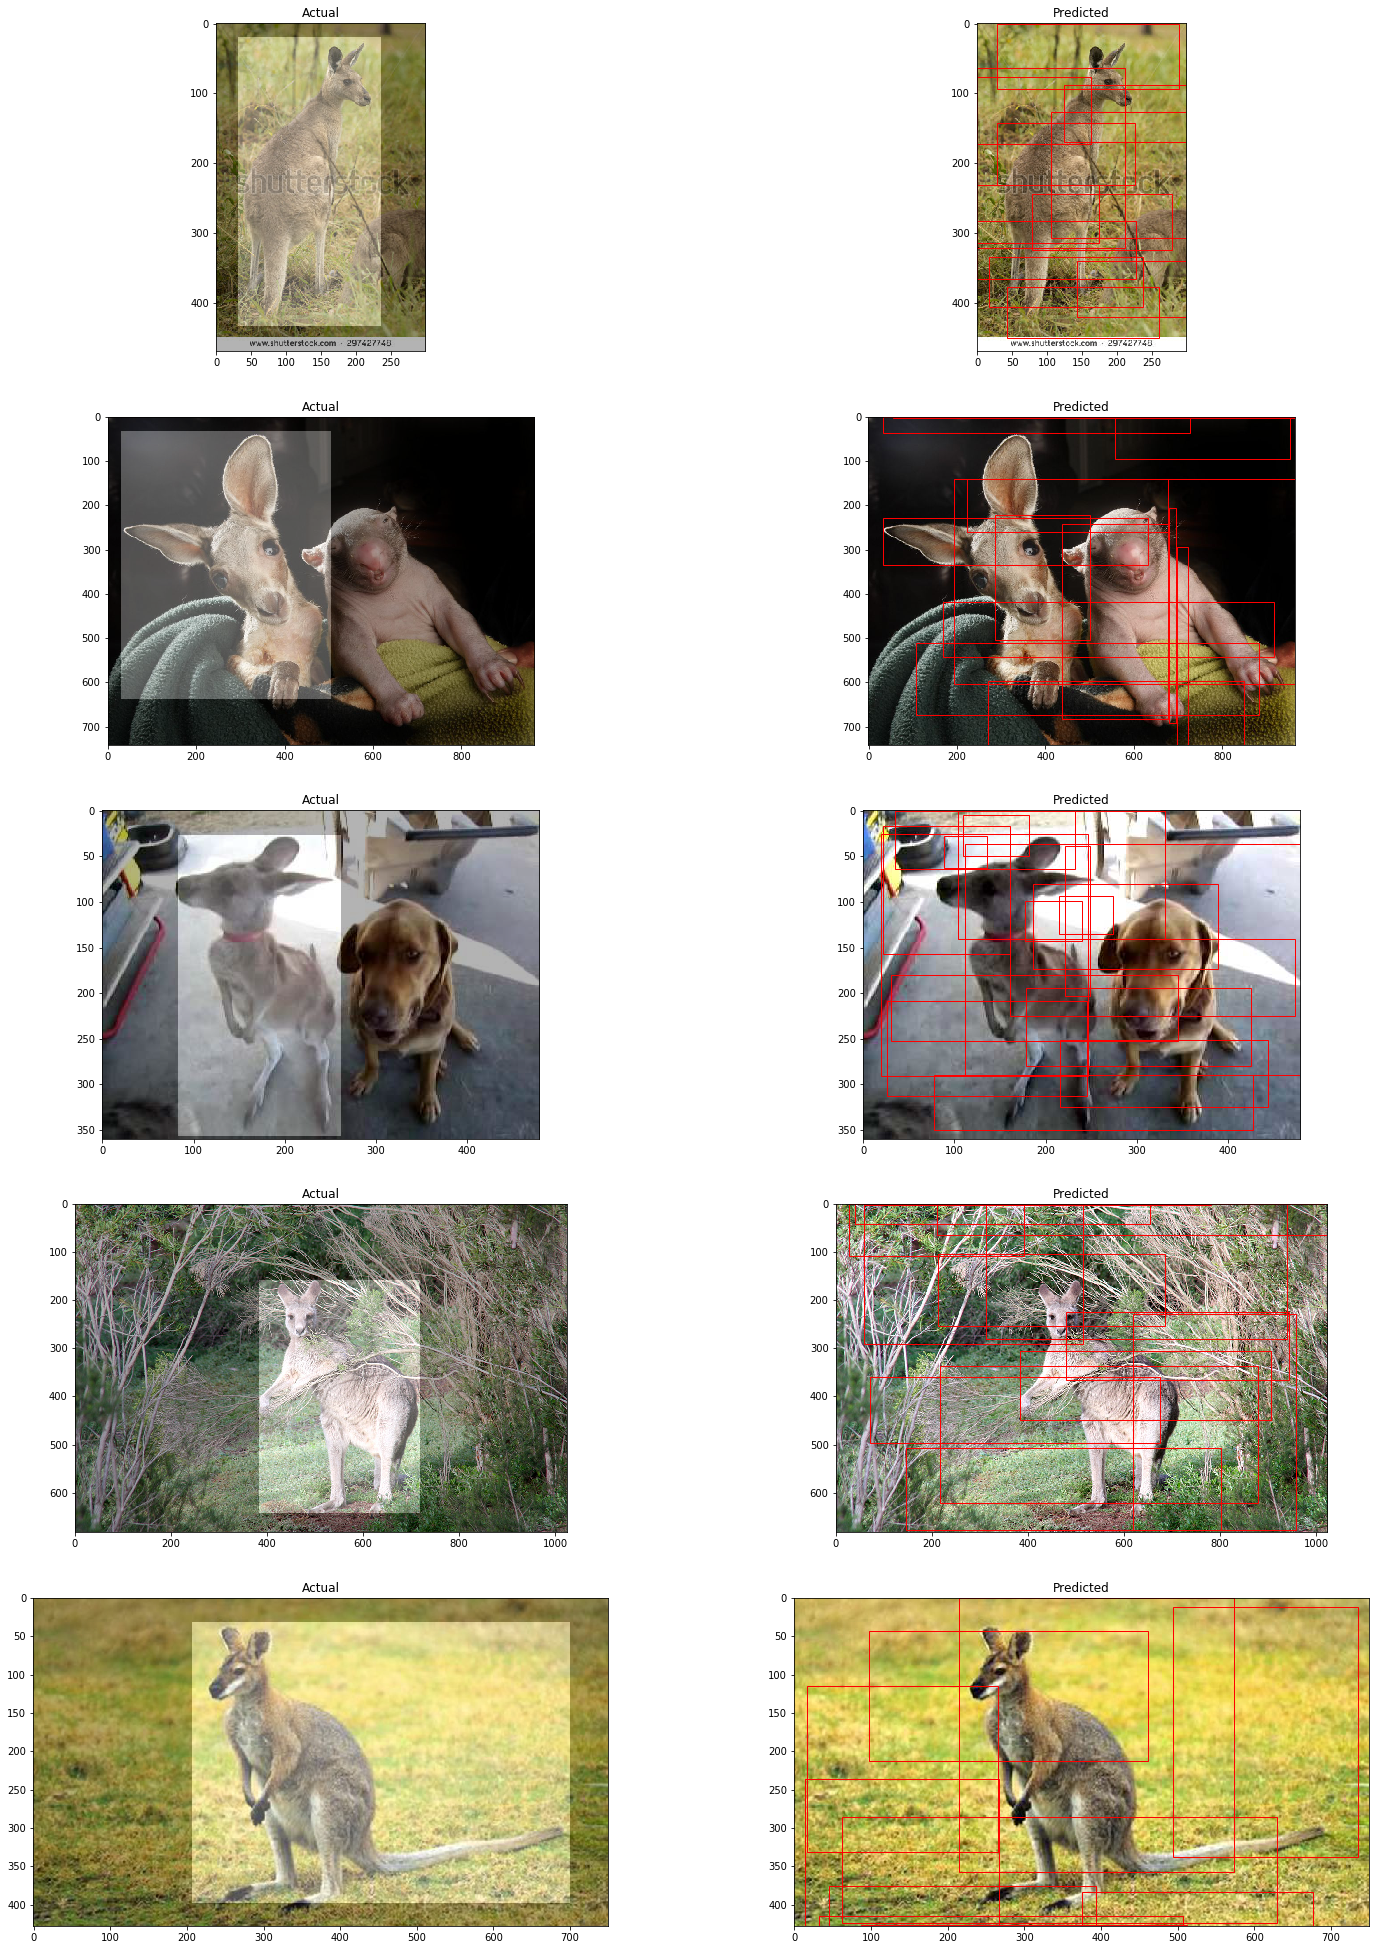

<function __main__.plot_actual_vs_predicted(dataset, model, cfg, n_images=5)>

In [35]:
# plota predições pro dataset de treino
plot_actual_vs_predicted(train_set, model, cfg)
plot_actual_vs_predicted

In [ ]:
# plota predições pro dataset de teste
plot_actual_vs_predicted(test_set, model, cfg)

# COLOCAR NOVAS IMAGENS NO TRAIN SET